<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/R3ab_Copy_of_Expression_of_Inflammatory_related_genes_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This look at the gene set enrichment analysis for MEFs and EBs using 4 sets of pathways. 

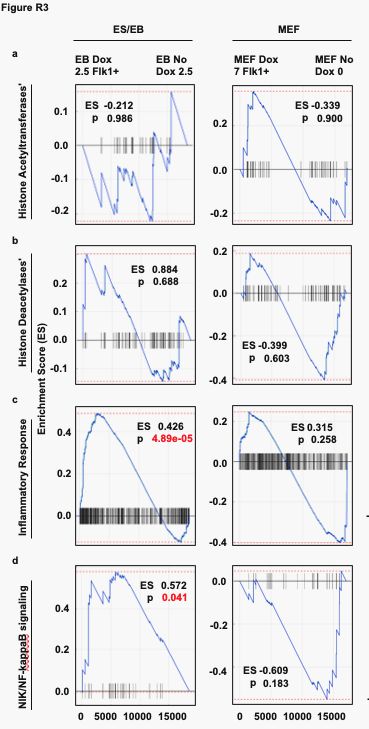

In [ ]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2','clusterProfiler','VennDiagram','fgsea','cowplot'
), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')
devtools::install_github("GSEA-MSigDB/GSEA_R")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'stringr' 'ggplot2'”
Installing package(s) 'BiocVersion', 'SummarizedExperiment', 'rhdf5',
  'SingleCellExperiment', 'limma', 'goseq',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db', 'wordcloud', 'plotrix',
  'DESeq2', 'clusterProfiler', 'VennDiagram', 'fgsea', 'cowplot'

also installing the dependencies ‘gridGraphics’, ‘Rhtslib’, ‘rjson’, ‘filelock’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘ggplotify’, ‘patchwork’, ‘lazyeval’, ‘zlibbioc’, ‘bitops’, ‘XML’, ‘Rsamtools’, ‘GenomicAlignments’, ‘restfulr’, ‘plogr’, ‘png’, ‘BiocFileCache’, ‘xtable’, ‘ggforce’, ‘ggrepel


✔  checking for file ‘/tmp/Rtmp3AYZPT/remotes4f7ed64cf0/rstudio-reticulate-d98c60e/DESCRIPTION’
─  preparing ‘reticulate’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘reticulate_1.22-9000.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




lifecycle (1.0.0 -> 1.0.1) [CRAN]
pillar    (1.6.2 -> 1.6.3) [CRAN]
tibble    (3.1.4 -> 3.1.5) [CRAN]


Installing 3 packages: lifecycle, pillar, tibble

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmp3AYZPT/remotes4f527a1aeb/GSEA-MSigDB-GSEA_R-8fbd326/DESCRIPTION’
─  preparing ‘GSEA’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘GSEA_1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)
library(GSEA)
library(fgsea)
library(VennDiagram)
library(cowplot)
library(dplyr)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

# Loading the gene list obtained from GO containg 4 categories (Hats, HDACs, Inflammatory related and NFkB pathwway related)
https://www.ebi.ac.uk/QuickGO/annotations?goUsage=descendants&goUsageRelationships=is_a,part_of,occurs_in&goId=GO:0004402&taxonId=10090&taxonUsage=descendants

In [ ]:
gene_list <- c(
  "nfkb" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Nf_kB.tsv",
  "hdac" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/HDAC_complex.tsv",
  "hat" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Hat.tsv",
  "inflammatory" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Inflammatory_go.tsv")

In [ ]:
for (i in 1:length(gene_list)){
  sprintf('wget -x -c -nH %s', gene_list[i]) %>% system()
}
gene_list <- gsub('https://s3.msi.umn.edu/', './', gene_list)
message(sprintf('all gene_list exist: %s', all(file.exists(gene_list))))

all gene_list exist: TRUE



In [ ]:
genes <- lapply(gene_list, function(g){read.table(g, header = TRUE, sep = '\t')})

In [ ]:
genes[["hdac_sub"]] <- genes[["hdac"]][grepl('histone', genes[["hdac"]]$GO.NAME),] #Subsetting Histone Deactylase complex

## Load processed scRNA-seq data for MEFs

In [ ]:
se_file <- c(
  "se" = "https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")

In [ ]:
for (i in 1:length(se_file)){
  sprintf('wget -x -c -nH %s', se_file[i]) %>% system()
}
se_file <- gsub('https://s3.msi.umn.edu/', './', se_file)
message(sprintf('all se_file exist: %s', all(file.exists(se_file))))

all se_file exist: TRUE



In [ ]:
se <- se_file %>%
  readRDS()

In [ ]:
se

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

In [ ]:
colData(se)

DataFrame with 15475 rows and 7 columns
                barcodes       group doublet_scores predicted_doublets
             <character>    <factor>      <numeric>          <logical>
1     AAACCTGTCTGTCTAT-1  MEF_Dox_D1      0.1233766              FALSE
2     AAACGGGGTAAACACA-1  MEF_Dox_D1      0.0725995              FALSE
3     AAACGGGTCGCGTAGC-1  MEF_Dox_D1      0.0780488              FALSE
4     AAAGATGGTCACCCAG-1  MEF_Dox_D1      0.0507812              FALSE
5     AAAGCAAAGAGCTATA-1  MEF_Dox_D1      0.2380952              FALSE
...                  ...         ...            ...                ...
15471 TTTATGCCATCCTAGA-1 MEF_Dox_D7b      0.1951220              FALSE
15472 TTTCCTCTCGTACCGG-1 MEF_Dox_D7b      0.0257104              FALSE
15473 TTTGGTTCATCTCGCT-1 MEF_Dox_D7b      0.0977444              FALSE
15474 TTTGGTTTCGTAGATC-1 MEF_Dox_D7b      0.1401274              FALSE
15475 TTTGGTTTCGTGGGAA-1 MEF_Dox_D7b      0.1951220              FALSE
                                  lat

## Calculating Diferential expression for Treatment (MEF_Dox_D7b) vs Control (MEF_NoDox)

In [ ]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
control <- colData(se)$group == 'MEF_NoDox'
treatment <- colData(se)$group == 'MEF_Dox_D7b'
pvalues_tc <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, treatment], X[i, control], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc_tc <- rowMeans(assays(se)$normalized_counts[, treatment]+1)/rowMeans(assays(se)$normalized_counts[, control]+1)
names(pvalues_tc) <- names(fc_tc) <- rowData(se)$name

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [ ]:
res_scrna <- data.frame(
  name = rowData(se)$name, 
  fc = fc_tc, 
  pvalue = pvalues_tc
)

In [ ]:
res_scrna$log2fc <- log2(fc_tc)

In [ ]:
head(res_scrna)

,name,fc,pvalue,log2fc
,<chr>,<dbl>,<dbl>,<dbl>
1,Mrpl15,0.8561015,1.588210e-40,-0.224146290
2,Lypla1,0.9869158,1.476162e-09,-0.019001027
3,Gm37988,0.9997660,4.958114e-01,-0.000337565
4,Tcea1,0.8246107,3.610119e-43,-0.278214927
5,Rgs20,0.9858808,2.354869e-05,-0.020514837
6,Atp6v1h,1.1638874,4.307872e-07,0.218951431


#RNAseq

## Load the bulk RNA-seq of Etv2 induction in ES/EB and calculating Differential expression of treatment (EB_Dox_D25_Flk1pos_Etv2) vs control (EB_NoDox_D25_Etv2) and calculate Differential expression using DESeq2

In [ ]:
se_rna <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))
se_rna <- DESeqDataSet(se_rna, design = ~ group)
se_rna <- estimateSizeFactors(se_rna)
se_rna <- DESeq(se_rna)
table(colData(se_rna)$group)
res <- results(se_rna, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_rna, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




         EB_Dox_D2_Etv2         EB_Dox_D25_Etv2 EB_Dox_D25_Flk1pos_Etv2 
                      2                       2                       2 
       EB_NoDox_D2_Etv2       EB_NoDox_D25_Etv2 
                      2                       2 

In [ ]:
head(res)

log2 fold change (MLE): group EB_Dox_D25_Flk1pos_Etv2 vs EB_NoDox_D25_Etv2 
Wald test p-value: group EB_Dox_D25_Flk1pos_Etv2 vs EB_NoDox_D25_Etv2 
DataFrame with 6 rows and 6 columns
               baseMean log2FoldChange     lfcSE       stat      pvalue
              <numeric>      <numeric> <numeric>  <numeric>   <numeric>
0610005C13Rik   22.5079      2.2176660  0.749898  2.9572892 0.003103568
0610007C21Rik  317.4460      0.3328445  0.226857  1.4671992 0.142321886
0610007L01Rik 2692.5195     -0.3353582  0.101905 -3.2909007 0.000998672
0610007N19Rik   78.4967     -0.0255568  0.346032 -0.0738567 0.941124427
0610007P08Rik 1393.9053      0.0461691  0.121432  0.3802055 0.703792879
0610007P14Rik 1402.6347     -0.0875989  0.137903 -0.6352198 0.525285091
                    padj
               <numeric>
0610005C13Rik 0.00845671
0610007C21Rik 0.23300793
0610007L01Rik 0.00302910
0610007N19Rik 0.97192676
0610007P08Rik 0.79528900
0610007P14Rik 0.64609835

# GSEA using HATs, HDACs, Inflammatory, and NfkB

## MEF scRNA GSEA

Arrange the fold change in a descending order

In [ ]:
fc <- res_scrna$log2fc

In [ ]:
names(fc) <- res_scrna$name

In [ ]:
fc <- na.omit(fc)
fc <- sort(fc, decreasing = TRUE)

In [ ]:
gene_sets <- lapply(genes, function(x){x$SYMBOL})
names(gene_sets) <- names(genes)

In [ ]:
str(fc)

 Named num [1:17010] 1.8 1.5 1.34 1.32 1.2 ...
 - attr(*, "names")= chr [1:17010] "Ptn" "Col3a1" "Selenop" "Igfbp4" ...


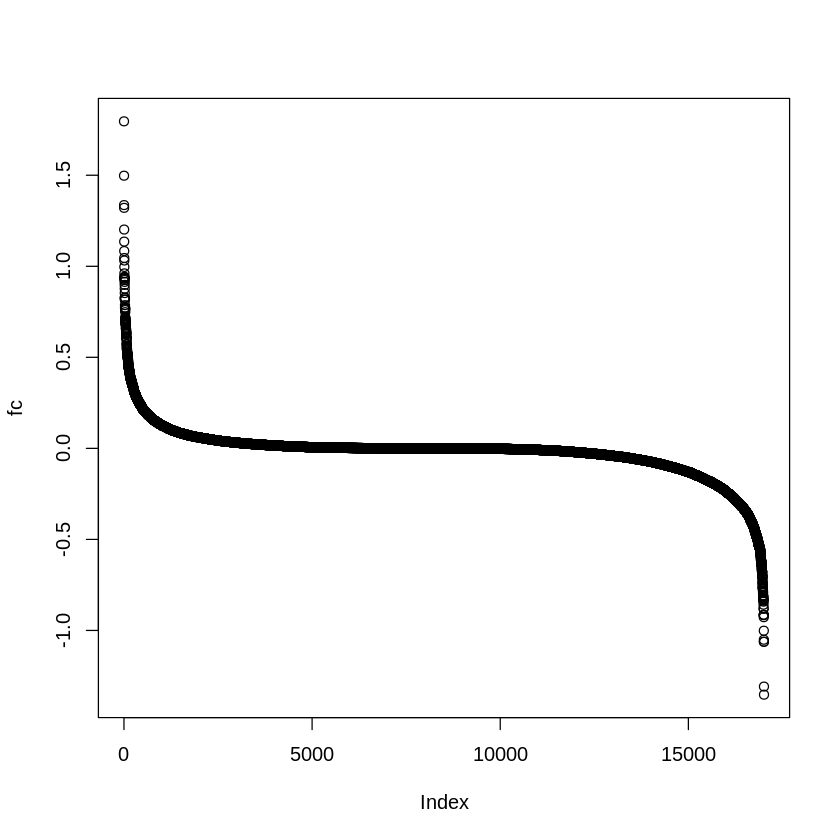

In [ ]:
plot(fc)

Using genes from each categories as a gene set 

In [ ]:
set.seed(1)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = fc,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,0.9007491,0.9358431,0.01421361,-0.3385241,-0.7275960,39,"Naa50 , Hat1 , Msl3 , Brca2 , Kat2a , Tada2a, Taf10 , Phf14 , Med24 , Kat14 , Brpf1 , Taf1 , Kat7"
hdac,0.6032689,0.9358431,0.02093714,-0.3990011,-0.9334043,73,"Anp32e , Cbx5 , Sap18 , Hdac3 , Mbd3 , Tbl1x , Suds3 , Sap30 , Hint1 , Csnk2a1, Ruvbl1 , Ruvbl2 , Ing2 , Mbd2 , Gatad2a, Brd8 , Mta2 , Rbbp7 , Ncor1 , Chd3 , Brms1 , Hdac1 , Chd4"
hdac_sub,0.9358431,0.9358431,0.01317096,-0.3222040,-0.6966871,40,"Cbx5 , Sap18, Hdac3, Tbl1x, Sap30, Hint1"
inflammatory,0.2575107,0.6437768,0.18591379,0.3145639,1.0368256,318,"Ptn , Igfbp4 , Cd47 , F2r , Vcam1 , Hif1a , Gja1 , Il1r1 , Plscr1 , Nfe2l2 , Ly96 , Mecom , Anxa1 , Cebpb , Lyn , Camk1d , Ninj1 , Psen2 , Aim2 , Kdm6b , Casp6 , Serpinb1a, Itgav , Sgms1 , Stat3 , Cxcl1 , Nfkbiz , Ccl6 , Fn1 , Pld3 , Tgfb1 , Tnfrsf1a , Scyl1 , Ap3b1 , Chst2 , F8 , Tlr4 , Hdac5 , Pla2g7 , Snap23"
nfkb,0.1825149,0.6437768,0.05313428,-0.6090626,-1.2270663,26,"Traf4, Irak2, Cops8, Akt1 , Chuk , Zfp91, Irak1, Tirap"


In [ ]:
sprintf('%s:p-value %f',fgseaRes[grepl('hat', fgseaRes$pathway),]$pathway, fgseaRes$pval)

[1] "hat:p-value 0.900749" "hat:p-value 0.603269" "hat:p-value 0.935843"
[4] "hat:p-value 0.257511" "hat:p-value 0.182515"

In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               fc) + labs(title=sprintf('%s: ES %f, p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$ES,fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
  })


In [ ]:
names(ep) <- names(genes)

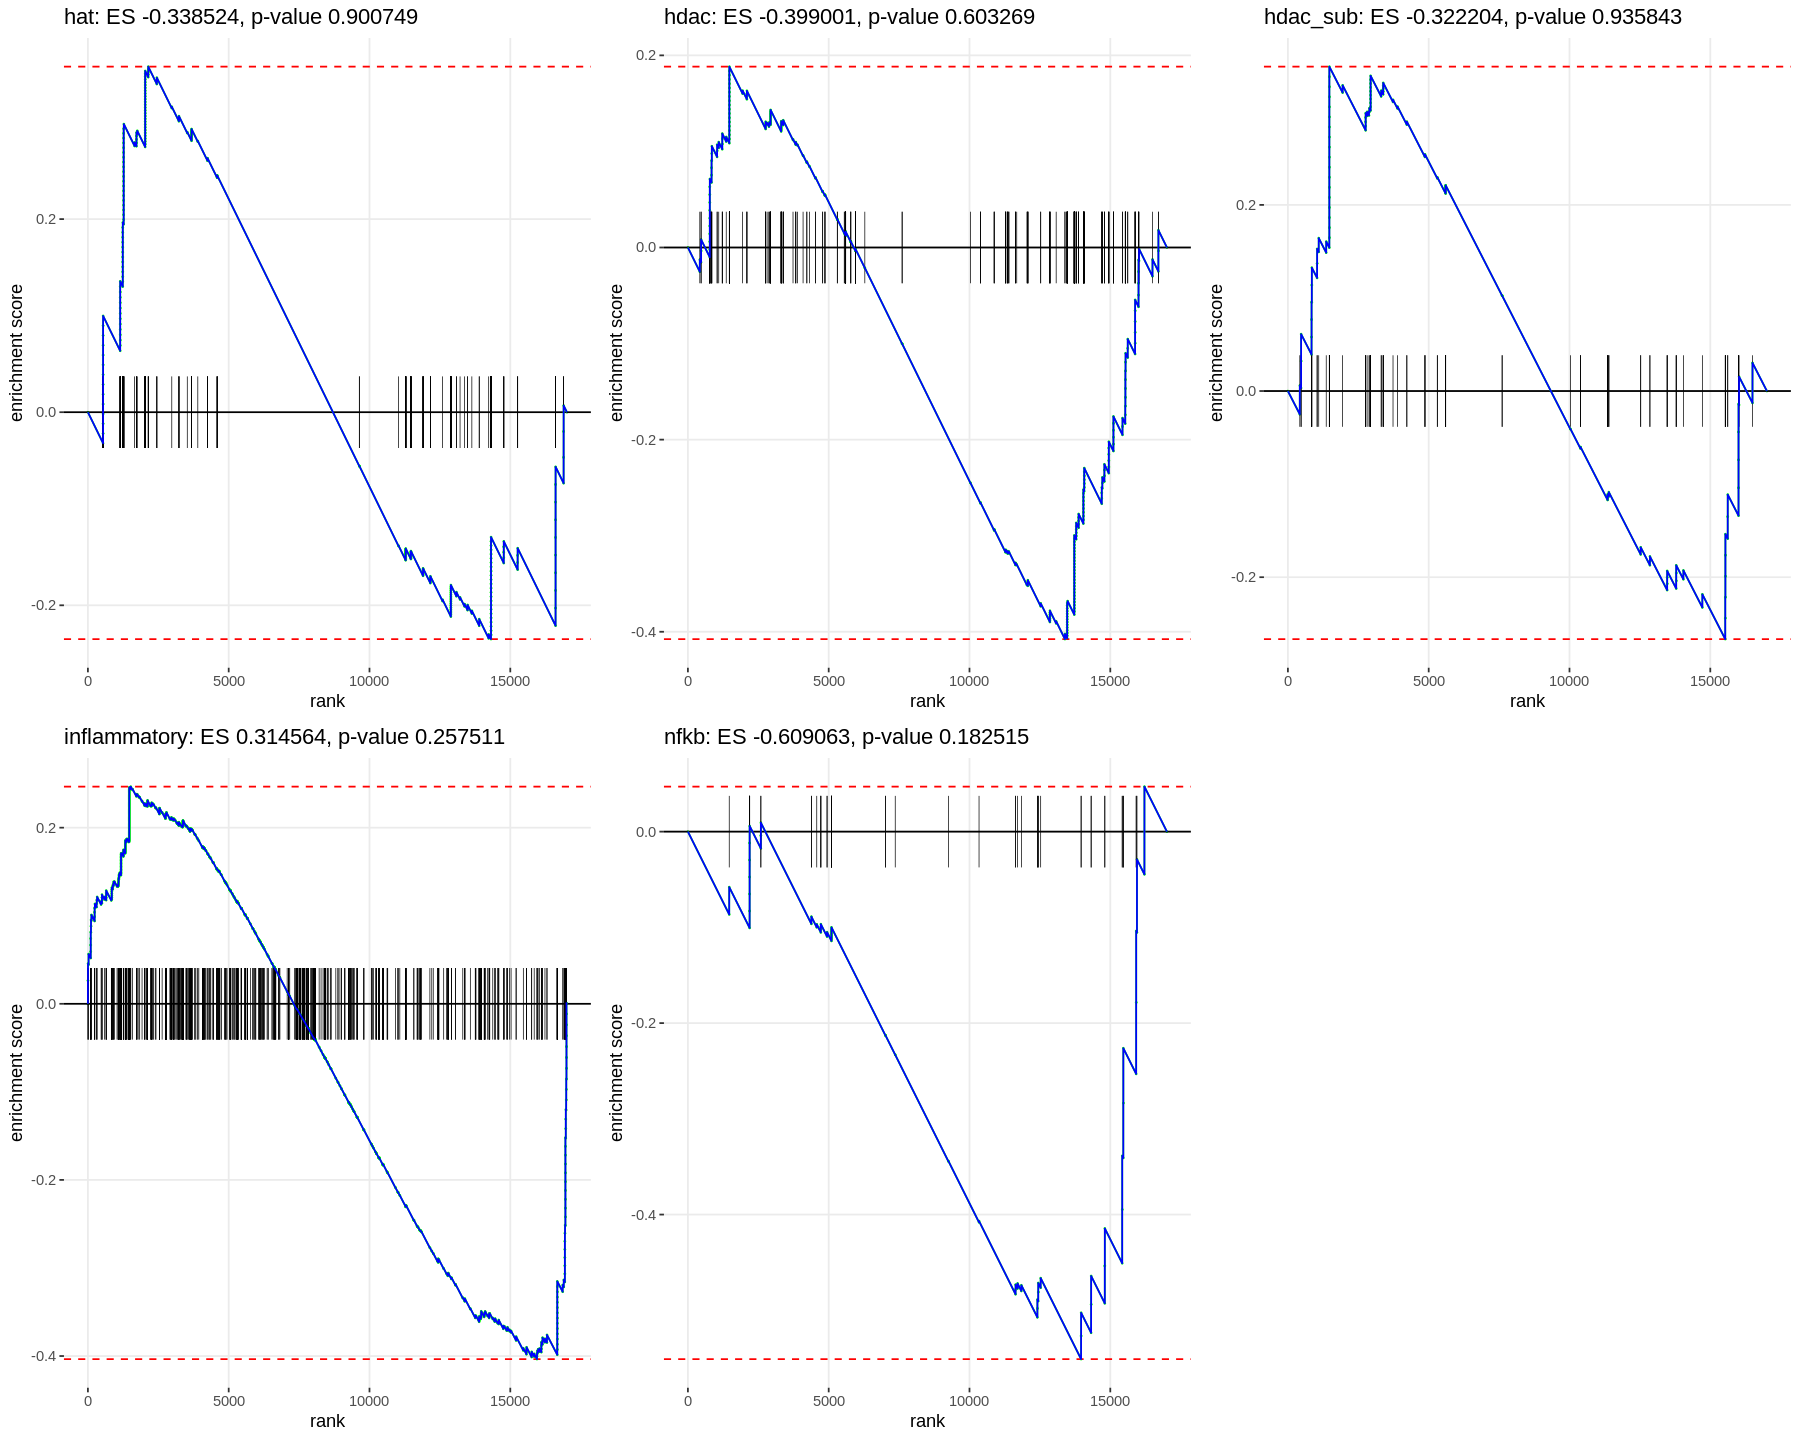

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

## RNA GSEA

Using log2fc from deseq2 as the preranked list and each categories as a gene set 

In [ ]:
l2fc <- res$log2FoldChange

In [ ]:
names(l2fc) <- rownames(res)

In [ ]:
l2fc <- na.omit(l2fc)
l2fc <- sort(l2fc, decreasing = TRUE)

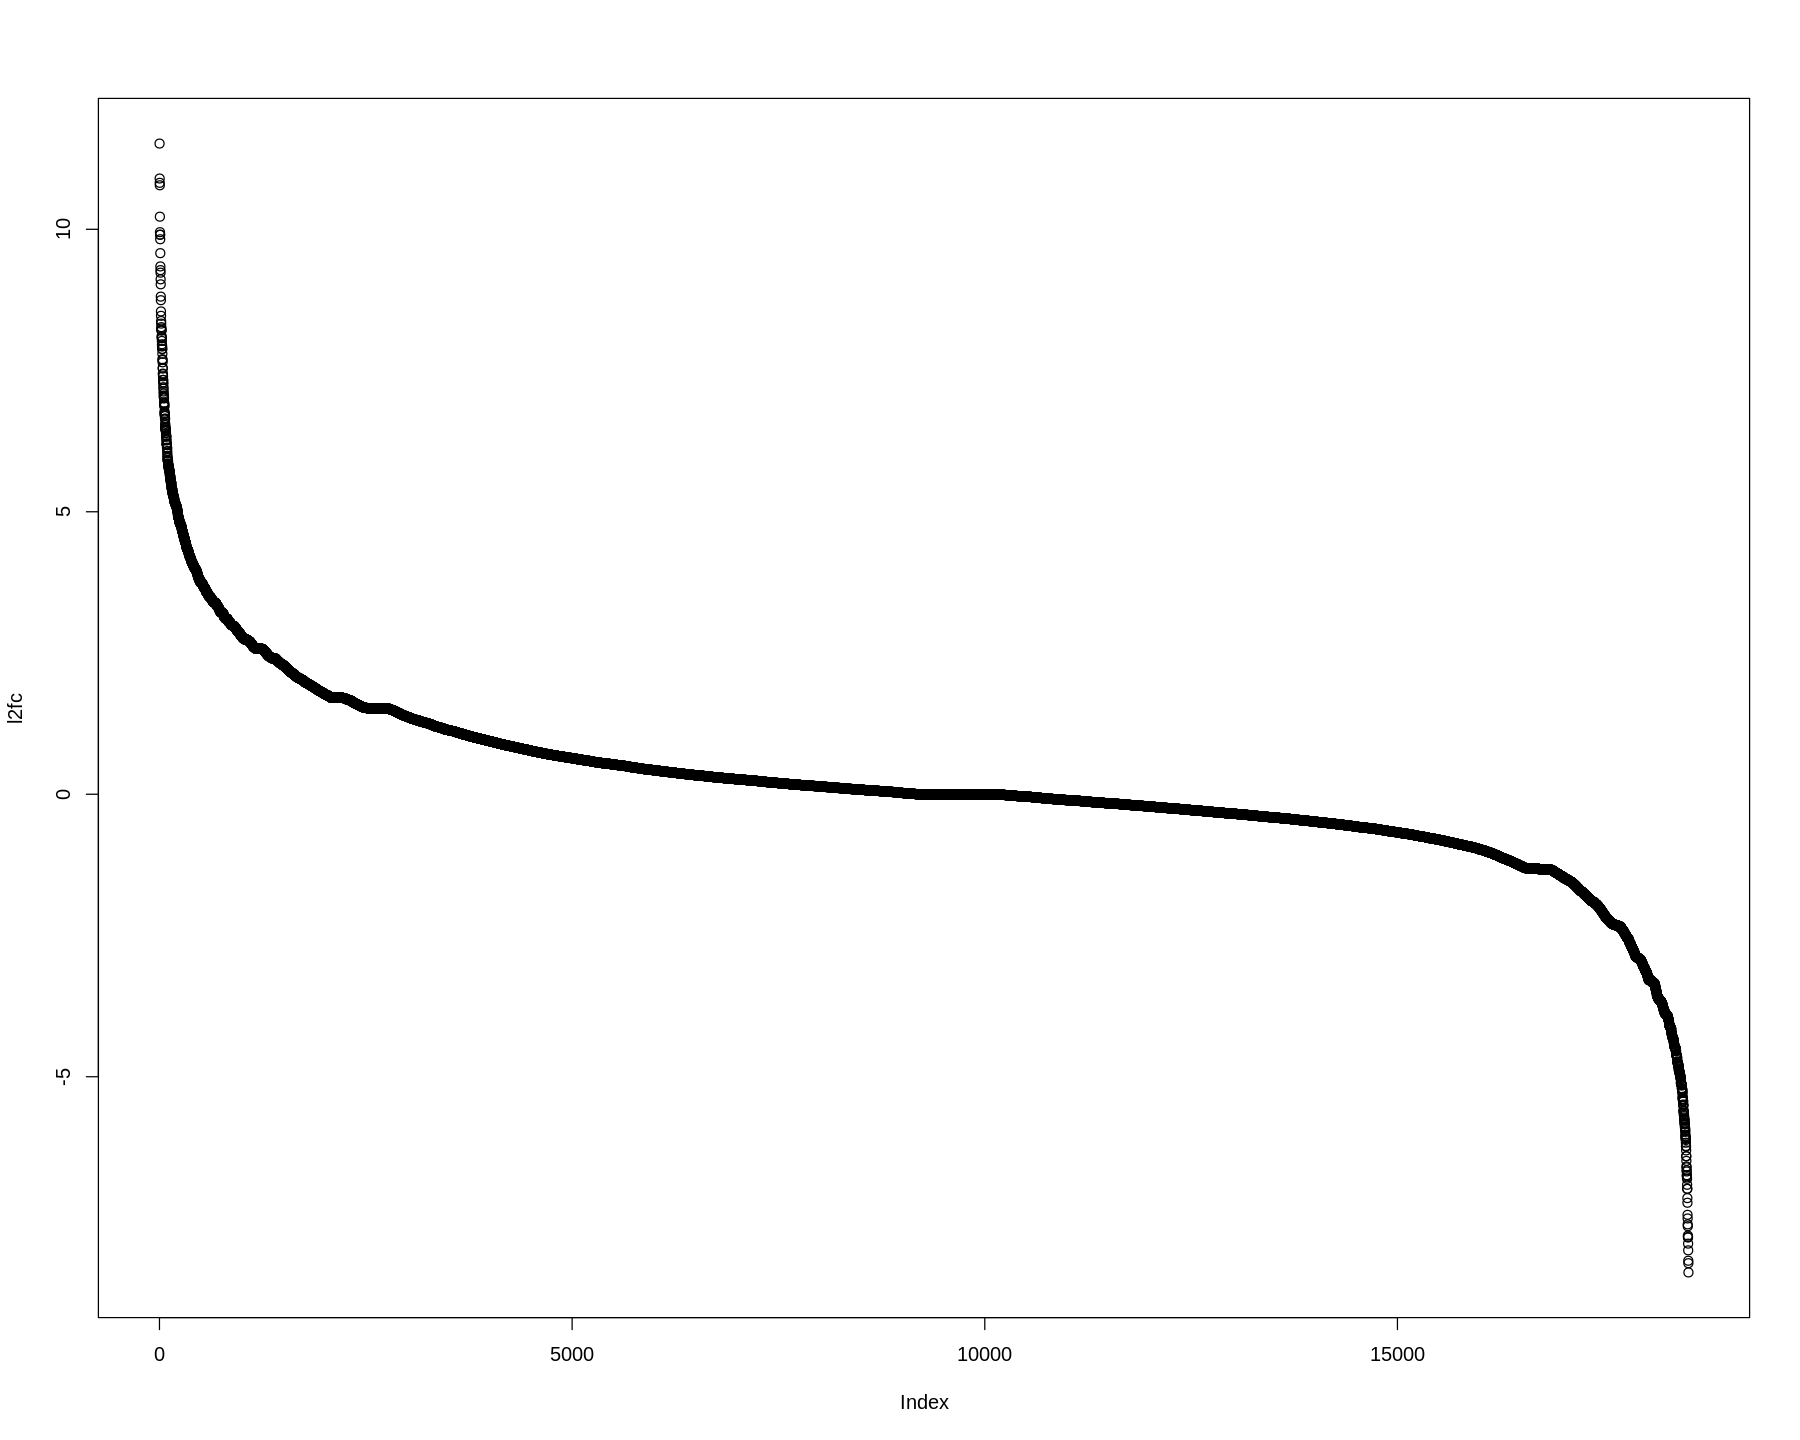

In [ ]:
plot(l2fc)

Gene set enrichment analysis

In [ ]:
set.seed(2)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = l2fc,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,0.9859872611,0.9859872611,0.03047550,-0.2126697,-0.6324653,33,"Hat1 , Mettl8, Tada3 , Taf10 , Naa50 , Tada2a, Taf9 , Ep300 , Supt7l, Kat2a , Gtf3c4, Epc2 , Atf2"
hdac,0.6878306878,0.8597883598,0.01960735,0.2933102,0.8842303,73,"Tal1 , Hdac7, Mecom"
hdac_sub,0.2275882013,0.3793136688,0.04722432,0.4278237,1.1736620,41,"Tal1 , Hdac7, Mecom"
inflammatory,0.0000489639,0.0002448195,0.55733224,0.4263945,1.5032058,382,"Ccr7 , Cxcl5 , Clec7a , Hc , Stab1 , Il18rap , P2rx1 , Pik3cg , C3ar1 , Cnr2 , C2cd4a , Igfbp4 , Ccl6 , Bmp6 , Cxcl3 , Naip2 , Hdac7 , Cxcl2 , Il1a , Ffar3 , Pf4 , Lat , Tlr12 , Tlr4 , Npff , F2r , Cd40 , Mecom , Ccr6 , Ly86 , Tnfrsf4 , Pla2g3 , Tlr5 , Il5ra , Cd180 , Bmp2 , Pla2g2e , Tnf , Gbp5 , Tac1 , Ciita , Serpinf2, F2 , Nr1h4 , Fcgr1 , Naip7 , Tlr6 , Il4 , Il15 , Il17c , Il1rl2 , Ly96 , Il31ra , Casp4 , Aif1 , Cxcl1 , Orm2 , Cxcr2 , Pnma1 , Havcr2 , Itgb2l , Rarres2 , Chia , Pla2g2d , Lbp , Ptgfr , Notch1 , Hfe , Ager , Naip1 , C4a , Ecm1 , Aim2 , Tlr3 , Camk1d , Plp1 , Chst1 , Ak7 , Fut7 , Pik3cd , Naip5 , Tnfaip3 , Fn1 , AI182371, Stat5b , Pstpip1 , Ccl1 , Defb1 , Il6 , Ggt5 , Selp , Cd47 , Sigirr , Naip6 , Cd300a , Ptgs1 , Il17f , Ccl22 , Krt16 , Adora3 , Ccr1 , Cxcr3 , Il18r1 , Nlrp3 , Orm3 , S100a8 , Tlr9 , Ccl17 , Ffar2 , Ccr1l1 , Nfkbid , Tcirg1 , Syk , Ccr4"
nfkb,0.0411940299,0.1029850746,0.12132984,0.5724843,1.4564862,28,"Tnfsf15, Tlr4 , Ikbke , Mas1 , Ripk3 , Card10 , Akt1 , Traf2 , Relb , Traf6 , Irak1 , Map3k7 , Zfp91 , Ppp4c , Malt1 , Irak2 , Dicer1 , Chuk , Nfkb2"


In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               l2fc) + labs(title=sprintf('%s: p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
               })

In [ ]:
names(ep) <- names(genes)

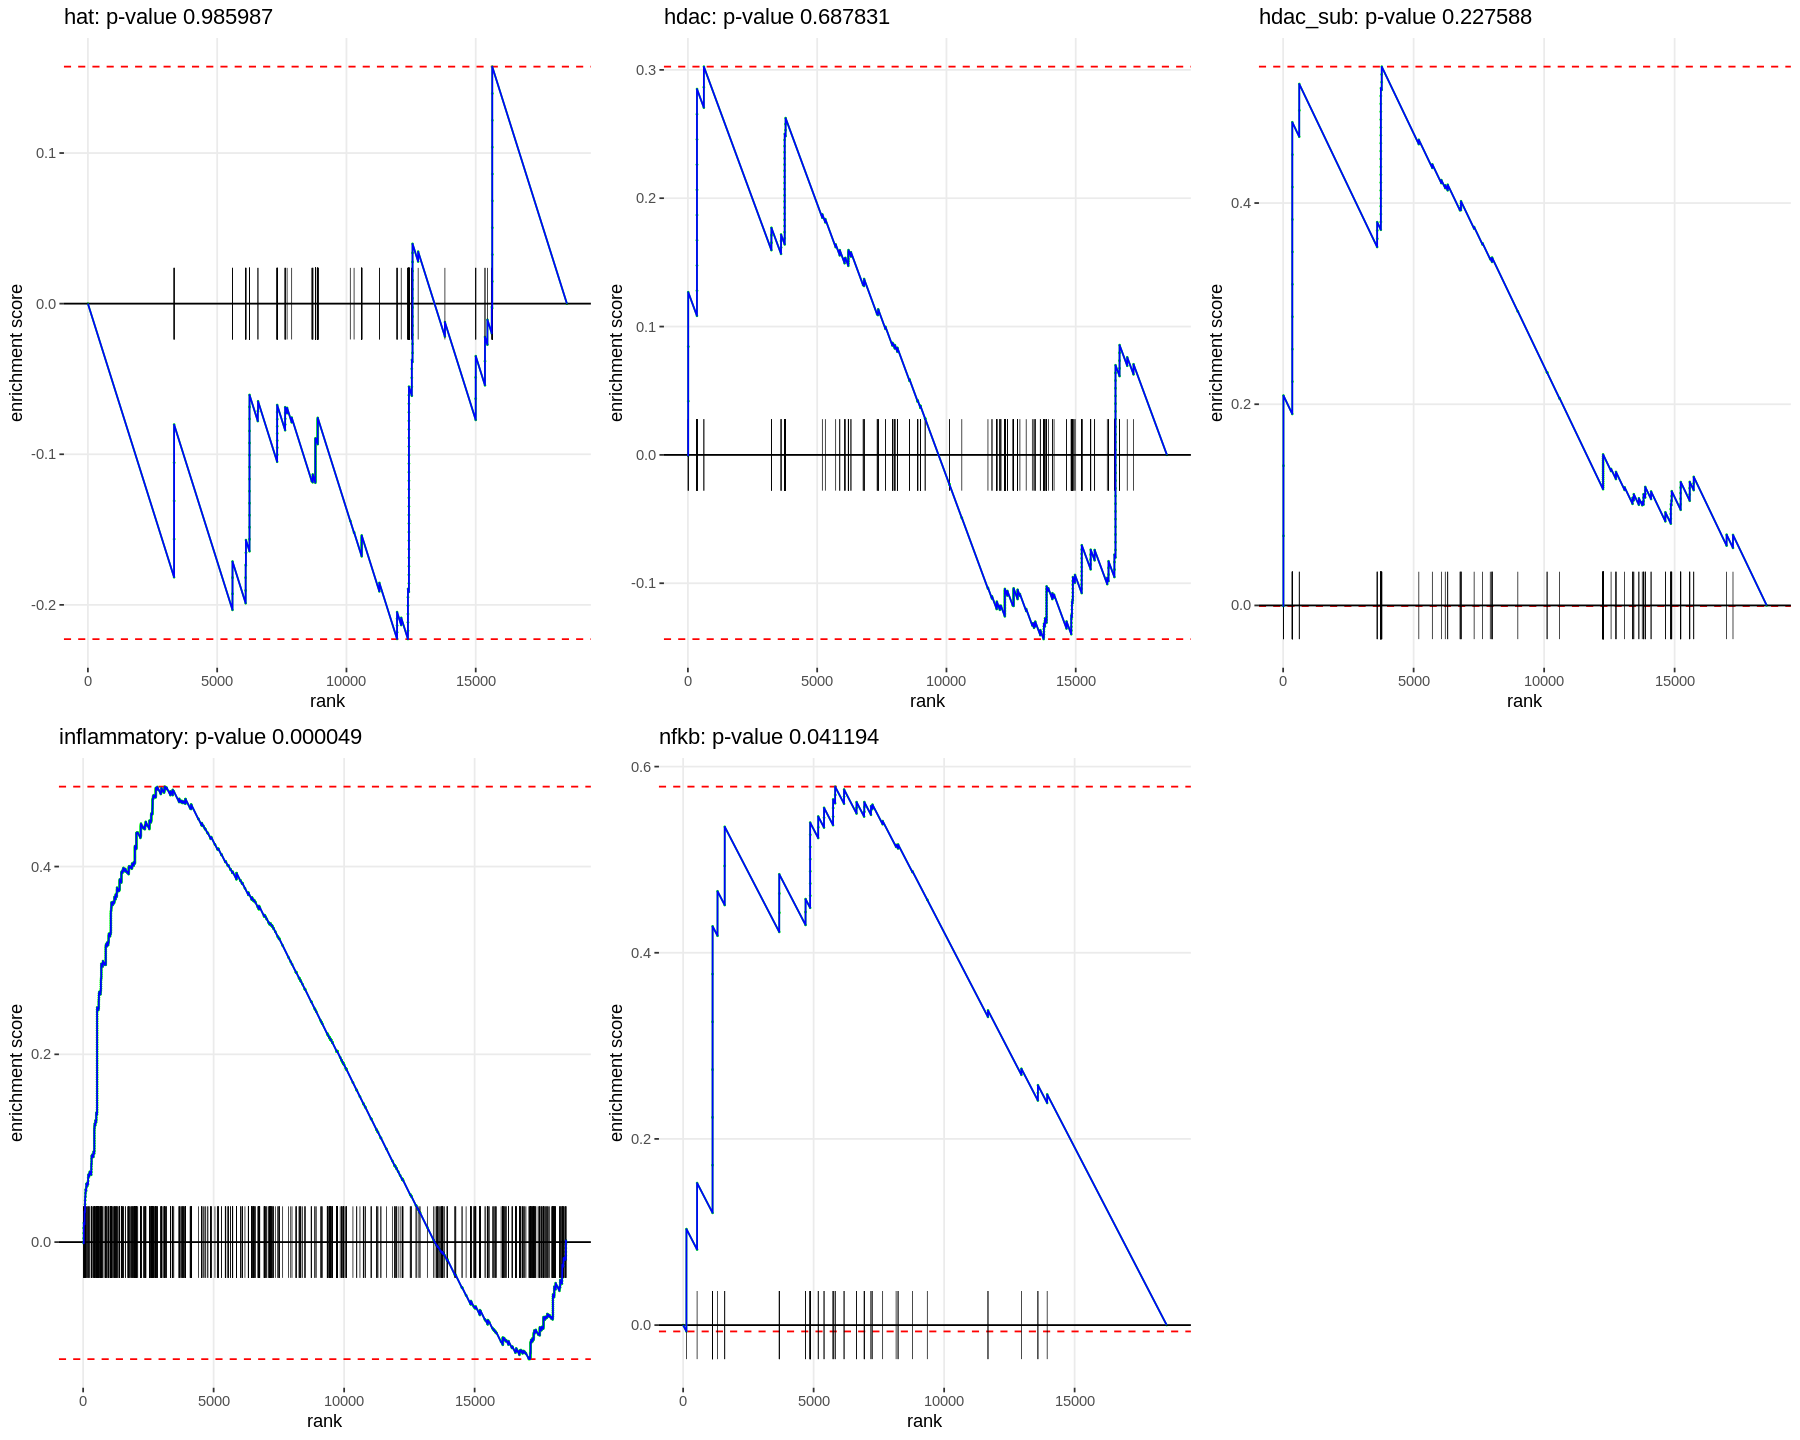

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

Inflammatory pathways are enriched in ES/EB system and not MEFs

In [ ]:
Sys.time() - start_time0

Time difference of 26.30388 mins

In [ ]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1                            
 [2] VennDiagram_1.6.20                       
 [3] futile.logger_1.4.3                      
 [4] fgsea_1.18.0                             
 [5] GSEA_1.2                                 